# Weather Prediction Rater

The following Jupyter Notebook is meant to visualize the differences between Weather Predictions and Weather Measurements

## STEP 1: Load enviornment variables and test API

In [1]:
import os
from dotenv import load_dotenv

# Load Enviornment variables
load_dotenv() 

True

In [2]:

import requests
from urllib.parse import quote

#TODO: Change to desired values
city_name = "New York"

#TODO: API KEY (put key in a .env file)
api_key = os.getenv("weatherApiKey")

# Make initial API call to test if working
url = f"https://api.weatherapi.com/v1/forecast.json?key={quote(api_key)}&q={quote(city_name)}&days=10&aqi=no&alerts=no"
x = requests.get(url)

print(url)
print(x.text)

https://api.weatherapi.com/v1/forecast.json?key=f2d55f87eb2143e9b20182545243012&q=New%20York&days=10&aqi=no&alerts=no
{"location":{"name":"New York","region":"New York","country":"United States of America","lat":40.7142,"lon":-74.0064,"tz_id":"America/New_York","localtime_epoch":1735796419,"localtime":"2025-01-02 00:40"},"current":{"last_updated_epoch":1735795800,"last_updated":"2025-01-02 00:30","temp_f":39.9,"is_day":0,"condition":{"text":"Partly cloudy","icon":"//cdn.weatherapi.com/weather/64x64/night/116.png","code":1003},"wind_mph":18.3,"wind_degree":268,"wind_dir":"W","pressure_in":29.78,"precip_in":0.0,"humidity":53,"cloud":25,"feelslike_f":30.8,"windchill_f":25.2,"heatindex_f":35.1,"dewpoint_f":30.4,"vis_miles":9.0,"uv":0.0,"gust_mph":25.6},"forecast":{"forecastday":[{"date":"2025-01-02","date_epoch":1735776000,"day":{"maxtemp_f":43.5,"mintemp_f":30.6,"avgtemp_f":35.2,"maxwind_mph":19.2,"totalprecip_in":0.0,"totalsnow_cm":0.0,"avgvis_miles":6.0,"avghumidity":73,"daily_will_it_r

# STEP 2: Create initial csv file

Below is a code cell that will format a basic csv file to analysis later

Metrics being tracked (each metric will have 240 future hourly prediction points unless modified including the actual reading):
- unix_time
- is_prediction
- temp_f
- is_day
- condition
- wind_mph
- wind_degree
- wind_dir
- pressure_in
- precip_in
- humidity
- cloud
- feelslike_f
- windchill_f
- heatindex_f
- dewpoint_f
- vis_miles
- uv
- gust_mph

In [3]:
# Unix Time
header_vars = ["measurement_time", "utime", "is_prediction", "temp_f", "is_day", "condition", "wind_mph", "wind_degree", "wind_dir", "pressure_in", "precip_in", "humidity", "cloud", "feelslike_f", "windchill_f", "heatindex_f", "dewpoint_f", "vis_miles", "uv", "gust_mph"]

# TODO: Change file name
csv_file_name = "data"

# Set CSV File Header (ONLY RUN ONCE PER FILE)
with open(f"{csv_file_name}.csv", "w") as file:
    header = header_vars[0]
    for var in header_vars[1:]:
        header += "," + var
    header += "\n"
    file.write(header)

## STEP 3: Collect Data

Below are two different cells. The first cell can be left running for however long the user wants and will collect data until the time allocated ends. The second cell will allow the user to manually call the cell however frequently they want to collect their data.

Format of data for both options (csv):

```csv
,utime,is_prediction,temp_f,is_day,condition,...
0,<unix time>,True,80,Partly Cloudly,...
...
```

### OPTION 1: Automatically aggrigate data

In [6]:
import time
import json
import pandas as pd


# Load Existing Data
df = pd.read_csv(f"{csv_file_name}.csv")

# How long should program run (in hours)
num_time_intervals = 5

# Constant for how long to sleep
secs_per_time_interval = 45 * 60 # 45 mins

# Keep running until num hours
for interval in range(num_time_intervals):
    
    # Make API Request
    response = requests.get(url)
    data = json.loads(response.text)

    """
    Format Current Measurement Data Entry
    """
    cur_measurement = data["current"]
    
    # Change measurment label
    cur_measurement["measurement_time"] = int(data["current"]["last_updated_epoch"]) 
    cur_measurement["utime"] = int(data["current"]["last_updated_epoch"])
    del cur_measurement["last_updated_epoch"]
    del cur_measurement["last_updated"]

    # Only keep condition name
    cur_measurement["condition"] = data["current"]["condition"]["text"]

    # Is Prediction?
    cur_measurement["is_prediction"] = False

    # Check if already added
    if len(df[df["measurement_time"] == cur_measurement["measurement_time"]]) != 0:
        print("NO UPDATE")
        short_time_interval = 20 * 60 # 20 mins
        time.sleep(short_time_interval)
        continue

    # Append to dataframe
    measurement_df = pd.DataFrame([cur_measurement])
    df = pd.concat([df, measurement_df], ignore_index=True)

    """
    Format Prediction Data Entries
    """
    for day in data["forecast"]["forecastday"]:
        for hour_prediction in day["hour"]:

            # Ignore preditions before most recent measurement
            if cur_measurement["measurement_time"] > hour_prediction["time_epoch"]:
                continue

            # Change measurement label
            hour_prediction["measurement_time"] = cur_measurement["measurement_time"] # Time of last valid measurement
            hour_prediction["utime"] = hour_prediction["time_epoch"]                  # Time of predicted
            del hour_prediction["time_epoch"]
            del hour_prediction["time"]


            # Only keep condition name
            hour_prediction["condition"] = hour_prediction["condition"]["text"]

            # Is Prediction?
            hour_prediction["is_prediction"] = True

            # Remove some predictions not in measurement
            del hour_prediction["will_it_rain"]
            del hour_prediction["chance_of_rain"]
            del hour_prediction["will_it_snow"]
            del hour_prediction["chance_of_snow"]
            del hour_prediction["short_rad"]
            del hour_prediction["diff_rad"]

            # Append to DataFrame
            prediction_df = pd.DataFrame([hour_prediction])
            df = pd.concat([df, prediction_df], ignore_index=True)

    # Write to CSV
    df.to_csv(f"{csv_file_name}.csv", index=False)

    # Sleep for an hour
    print(f"Time interval: {interval}")
    time.sleep(secs_per_time_interval)


/tmp/ipykernel_76052/3027690614.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, measurement_df], ignore_index=True)


Hour 0


KeyboardInterrupt: 

## OPTION 2: Manually Aggrigate Data

In [7]:
import json
import sys
import pandas as pd


# Load Existing Data
df = pd.read_csv(f"{csv_file_name}.csv")


# Make API Request
response = requests.get(url)
data = json.loads(response.text)

"""
Format Current Measurement Data Entry
"""
cur_measurement = data["current"]

# Change measurment label
cur_measurement["measurement_time"] = int(data["current"]["last_updated_epoch"]) 
cur_measurement["utime"] = int(data["current"]["last_updated_epoch"])
del cur_measurement["last_updated_epoch"]
del cur_measurement["last_updated"]

# Only keep condition name
cur_measurement["condition"] = data["current"]["condition"]["text"]

# Is Prediction?
cur_measurement["is_prediction"] = False

# Check if already added
if len(df[df["measurement_time"] == cur_measurement["measurement_time"]]) != 0:
    print("NO UPDATE")
    sys.exit(0)

# Append to dataframe
measurement_df = pd.DataFrame([cur_measurement])
df = pd.concat([df, measurement_df], ignore_index=True)

"""
Format Prediction Data Entries
"""
for day in data["forecast"]["forecastday"]:
    for hour_prediction in day["hour"]:

        # Ignore preditions before most recent measurement
        if cur_measurement["measurement_time"] > hour_prediction["time_epoch"]:
                continue

        # Change measurement label
        hour_prediction["measurement_time"] = cur_measurement["measurement_time"] # Time of last valid measurement
        hour_prediction["utime"] = hour_prediction["time_epoch"]                  # Time of predicted
        del hour_prediction["time_epoch"]
        del hour_prediction["time"]


        # Only keep condition name
        hour_prediction["condition"] = hour_prediction["condition"]["text"]

        # Is Prediction?
        hour_prediction["is_prediction"] = True

        # Remove some predictions not in measurement
        del hour_prediction["will_it_rain"]
        del hour_prediction["chance_of_rain"]
        del hour_prediction["will_it_snow"]
        del hour_prediction["chance_of_snow"]
        del hour_prediction["short_rad"]
        del hour_prediction["diff_rad"]

        # Append to DataFrame
        prediction_df = pd.DataFrame([hour_prediction])
        df = pd.concat([df, prediction_df], ignore_index=True)

# Write to CSV
df.to_csv(f"{csv_file_name}.csv", index=False)
print("Success")

NO UPDATE


SystemExit: 0

/home/jodab/testfiles/data_science/env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# STEP 4: Visualize Data

After you have collected data, run the following code cell to create a visual representation comparing the predictions to the measurements

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Import data from our csv
df = pd.read_csv(f"{csv_file_name}.csv")

# Extract all measurments from df
measurements_df = df[df['is_prediction'] == False]

# Seperate Time and Other units
measurement_time = measurement_df['utime'].tolist()
measurement_temp = measurement_df['temp_f'].tolist()

# Seperate each prediction by measurment time
prediction_dfs = []
for time in measurement_time[0::10]:
    prediction_dfs.append(df[(df['is_prediction'] == True) & (df['measurement_time'] == time)])
print(len(prediction_dfs))

1


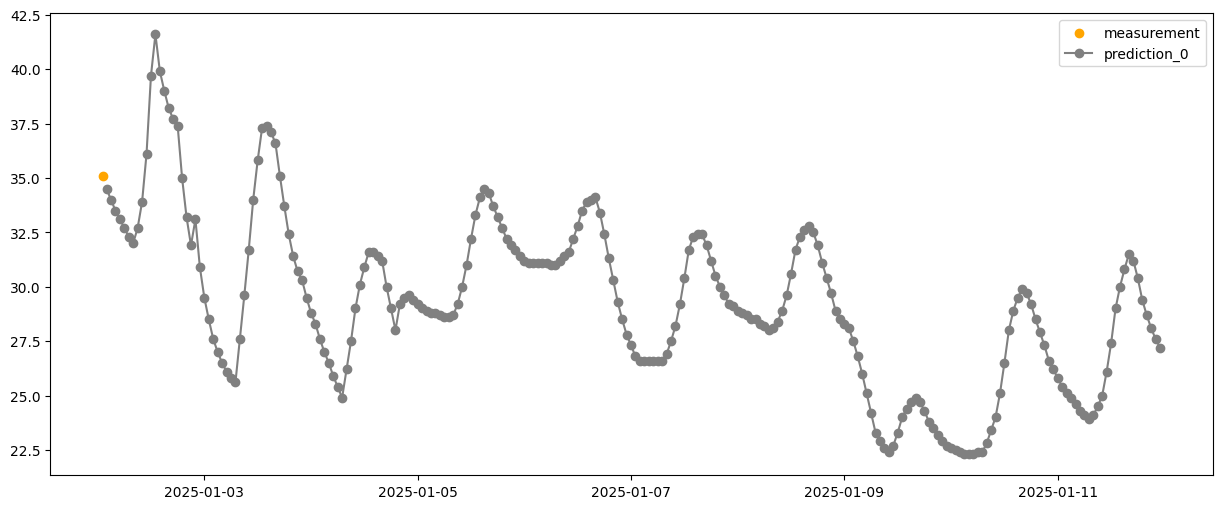

In [9]:
# Create matplotlib figure
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)

# Format Unix time on graph to be human-readable
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=6))

# Create a connected plot of measured temperatures
human_readable_measurement_time = [datetime.fromtimestamp(ts) for ts in measurement_time]
ax.scatter(human_readable_measurement_time, measurement_temp, c='orange', marker='o', label='measurement')

# Create a connected plot of every all predicted temperature from every 10th measurment time
for i, prediction in enumerate(prediction_dfs):
    predict_time = prediction['utime'].tolist()
    predict_temp = prediction['temp_f'].tolist()
    human_readable_prediction_time = [datetime.fromtimestamp(ts) for ts in predict_time]
    ax.plot(human_readable_prediction_time, predict_temp, c='gray', marker='o', label=f'prediction_{i}')

plt.legend(loc='upper right')
plt.show()